In [1]:
#Deep Convolutional Generative Adversarial Network
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import visdom 
from matplotlib import pyplot as plt

In [2]:
# 내 얼굴 사진들을 이미지 폴더로 해서 불러오기

In [3]:
address='C:\\Users\\IDSL\\Desktop\\파이썬공부\\파이토치\\origin_data'

In [4]:
trans=torchvision.transforms.Compose([torchvision.transforms.Resize((64,128))])
train_data=torchvision.datasets.ImageFolder(address,transform=trans)

<PIL.Image.Image image mode=RGB size=128x64 at 0x21D04F365C0>
0


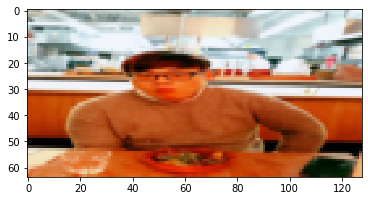

In [5]:
for _,i in enumerate(train_data):
    data,value=i
    data.save('C:\\Users\\IDSL\\Desktop\\파이썬공부\\파이토치\\custom_data\\%d.jpeg'%(_)) #data 변경 후 저장
    if _==10:
        plt.imshow(data)
        print(data)
        print(value)

In [2]:
# MNIST DATA로 진행해보자
mnist_train=torchvision.datasets.MNIST('./',True,transform=torchvision.transforms.ToTensor(),download=True)
train_data_loader=torch.utils.data.DataLoader(mnist_train,batch_size=256,
    shuffle=True,
    drop_last=True,
    )

In [23]:
#GAN
class generator(nn.Module):
    def __init__(self):
        # input shape 1, 28, 28 
        super().__init__()
        self.gen=nn.Sequential(nn.Linear(100,256),nn.Dropout(),nn.ReLU(),nn.Linear(256,784),nn.ReLU())
    def forward(self,input_data):
        out=self.gen.forward(input_data)
        return out
class discriminator(nn.Module):
    def __init__(self):
        # input shape 1, 28, 28 
        super().__init__()
        self.layers=nn.Sequential(nn.Linear(784,256),nn.Dropout(),nn.ReLU(),nn.Linear(256,1),nn.Sigmoid())
    def forward(self,input_data):
        input_data=input_data.reshape(-1,784)
        out=self.layers.forward(input_data)
        return out

In [24]:
g=generator().to(device)
d=discriminator().to(device)

cost_d_list=[]
cost_g_list=[]

optimizer_d=torch.optim.Adam(d.parameters())
optimizer_g=torch.optim.Adam(g.parameters())

for i in range(100):
    if i%10==0:
        print(i)
    avg_cost_d=0
    avg_cost_g=0
    batch=0
    for data,label in train_data_loader:
        data=data.to(device)
        
        # 구분자 학습
        optimizer_d.zero_grad()
        
        # 1. 데이터 생성 + cost 계산 .
        
        z=torch.randn(len(label),100).to(device)
        generated_data=g.forward(z)
        generated_data_label=torch.zeros(len(label),1).to(device)
        
        discriminate_generated_data=d.forward(generated_data)
        
        cost_d_1=F.binary_cross_entropy(discriminate_generated_data,generated_data_label)
        
        # 2. 실제 데이터 discriminate 후 cost 계산
        discriminate_data=d.forward(data)
        data_label=torch.ones(len(label),1).to(device)
        cost_d_2=F.binary_cross_entropy(discriminate_data,data_label).to(device)
        
        cost_d=cost_d_1+cost_d_2
        
        cost_d.backward()
        optimizer_d.step()
        
        # 2. max(log(D(G(z)))
        optimizer_g.zero_grad()
        z=torch.randn(len(label),100).to(device)
        generated_data=g.forward(z)
        generated_data_fake_label=torch.ones(len(label),1).to(device)
        discriminate_generated_data=d.forward(generated_data)
        cost_g=F.binary_cross_entropy(discriminate_generated_data,generated_data_fake_label)
        cost_g.backward()
        optimizer_g.step()
        
        avg_cost_d+=cost_d
        avg_cost_g+=cost_g
        batch+=1
    cost_d_list.append(avg_cost_d/batch)
    cost_g_list.append(avg_cost_g/batch)
        

0
10
20
30
40
50
60
70
80
90


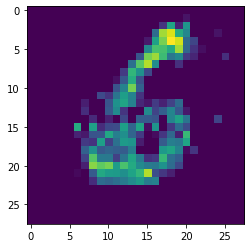

In [31]:
z=torch.randn(1,100).to(device)
generated_data=g.forward(z)
plt.imshow(generated_data.to('cpu').reshape(28,28).detach().numpy())

In [15]:
#DCGAN

class Generator(nn.Module):
    def __init__(self):
        # input shape 1, 28, 28 
        super().__init__()
        self.gen=nn.Sequential(nn.ConvTranspose2d(100,128,15,1,0),nn.BatchNorm2d(128),nn.ReLU(),nn.ConvTranspose2d(128,256,14,1,0),nn.BatchNorm2d(256),nn.Tanh())
        # 256,4,4
    def forward(self,input_data):
        return self.gen.forward(input_data)
    
class Discriminator(nn.Module):
    def __init__(self):
        # input shape 1, 28, 28 
        super().__init__()
        self.layers=nn.Sequential(nn.Conv2d(1,64,3,1,1),nn.BatchNorm2d(64),nn.LeakyReLU(),nn.Conv2d(64,128,3,1,1),nn.BatchNorm2d(128),nn.LeakyReLU())
        #256*28*28
        self.fc_layers=nn.Sequential(nn.Linear(128*28*28,100),nn.Dropout(),nn.ReLU(),nn.Linear(100,1),nn.ReLU())
        # 256,4,4
    def forward(self,input_data):
        out=self.layers.forward(input_data)
        out=out.reshape(-1,128*28*28)
        out=self.fc_layers.forward(out)
        return out
    
        

In [16]:
if torch.cuda.is_available():
    device='cuda:%d'%torch.cuda.current_device()
else:
    device='cpu'


In [17]:
g=Generator().to(device)
d=Discriminator().to(device)

cost_d_list=[]
cost_g_list=[]

optimizer_d=torch.optim.Adam(d.parameters())
optimizer_g=torch.optim.Adam(g.parameters())
g.train()
d.train()
for i in range(100):
    if i%10==0:
        print(i)
    avg_cost_d=0
    avg_cost_g=0
    batch=0
    for data,label in train_data_loader:
        data=data.to(device)
        
        # 구분자 학습
        optimizer_d.zero_grad()
        
        # 1. 데이터 생성 + cost 계산 .
        
        z=torch.randn(len(label),100,1,1).to(device)
        generated_data=g.forward(z)
        generated_data_label=torch.zeros(len(label),1).to(device)
        
        discriminate_generated_data=d.forward(generated_data)
        
        cost_d_1=F.binary_cross_entropy(discriminate_generated_data,generated_data_label)
        
        # 2. 실제 데이터 discriminate 후 cost 계산
        discriminate_data=d.forward(data)
        data_label=torch.ones(len(label),1).to(device)
        cost_d_2=F.binary_cross_entropy(discriminate_data,data_label).to(device)
        
        cost_d=cost_d_1+cost_d_2
        
        cost_d.backward()
        optimizer_d.step()
        
        # 2. max(log(D(G(z)))
        optimizer_g.zero_grad()
        z=torch.randn(len(label),100,1,1).to(device)
        generated_data=g.forward(z)
        generated_data_fake_label=torch.ones(len(label),1).to(device)
        discriminate_generated_data=d.forward(generated_data)
        cost_g=F.binary_cross_entropy(discriminate_generated_data,generated_data_fake_label)
        cost_g.backward()
        optimizer_g.step()
        
        avg_cost_d+=cost_d
        avg_cost_g+=cost_g
        batch+=1
    cost_d_list.append(avg_cost_d/batch)
    cost_g_list.append(avg_cost_g/batch)
        

0


RuntimeError: CUDA out of memory. Tried to allocate 196.00 MiB (GPU 0; 3.00 GiB total capacity; 1.95 GiB already allocated; 22.30 MiB free; 27.58 MiB cached)